In [1]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook is inspired by and based on [this demonstration of VAE in keras](https://github.com/msurtsukov/ae_vae_gan)

In [2]:
%matplotlib inline

In [3]:
from torchsummary import summary
import seaborn as sns
sns.set()

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
print(device)

cuda:0


In [6]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

In [7]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
#     transforms.Normalize((0.1307,), (0.3081,))
])

In [8]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [9]:
data_root = '/home/rads/datasets/torchvision_datasets'

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

In [11]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

In [12]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

#     plt.show()
    return fig


In [13]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        test_batch = [x.to(device) for x in test_batch]
        out = model(test_batch)
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [14]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, show=True, conditional=True, condition=None):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])
            
            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)
            if conditional:
                if condition is None:
                    cur_condition = i%10
                else:
                    cur_condition = condition
                label = model.embedding(torch.tensor(cur_condition)[None, ].to(device))
                z_torch = torch.cat([z_torch, label], dim=1)
            x_decoded = model.decoder(z_torch).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
#         plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

In [15]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [16]:
class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape, embedding_dim, n_classes):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )
        input_dim = np.prod(input_shape)
        self.embedding_dim = embedding_dim
        self.n_classes = n_classes
        
        self.embedding = torch.nn.Embedding(self.n_classes, self.embedding_dim)
        self.encoder = nn.Sequential(*[
            nn.Linear(input_dim + self.embedding_dim, intermediate_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], intermediate_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3)
        ])
        
        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim)# <YOUR CODE HERE>
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)# <YOUR CODE HERE> 
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim + self.embedding_dim, intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[1], intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], input_dim),
            nn.Sigmoid(),
            RestoreShape(input_shape)
        ])
    
    def _encode(self, x):
        latent_repr = self.encoder(x)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = torch.exp(log_sigma_values) * sample + mu_values# <YOUR CODE HERE>
        return latent_sample
    
    def encode(self, data, label):
        if isinstance(label, list):
            if isinstance(label[0], int):
                label = torch.tensor(label).type(torch.LongTensor).to(data.device)
        elif isinstance(label, int):
            label = torch.tensor(label).type(torch.LongTensor)[None].to(data.device)
        preprocessed_label = self.embedding(label)
        data = torch.flatten(data, start_dim=1)
        print(data.shape, preprocessed_label.shape)
        return self._encode(torch.cat([data, preprocessed_label], dim=1))
    
    def decode(self, latent_repr, label):
        if isinstance(label, list):
            if isinstance(label[0], int):
                label = torch.tensor(label).type(torch.LongTensor).to(latent_repr.device)
        elif isinstance(label, int):
            label = torch.tensor(label).type(torch.LongTensor)[None].to(latent_repr.device)

        preprocessed_label = self.embedding(label)
        print(latent_repr.shape, preprocessed_label.shape)

        return self.decoder(torch.cat([latent_repr, preprocessed_label], dim=1))

    def forward(self, x, raw_sample=None):
        data, label = x
        preprocessed_label = self.embedding(label)
        data = torch.flatten(data, start_dim=1)
#         print(preprocessed_label.shape, data.shape, torch.cat([data, preprocessed_label], dim=1).shape)
        mu_values, log_sigma_values, latent_repr = self._encode(torch.cat([data, preprocessed_label], dim=1))

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        
        reconstructed_repr = self.decoder(torch.cat([latent_sample, preprocessed_label], dim=1))
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [17]:
def train_cvae(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch in tqdm.tqdm_notebook(train_loader, leave=False):
            batch = [x.to(device) for x in batch]
            predictions, latent, mu_values, log_sigma_values = model(batch)

            kl_loss = 0.5 * torch.mean(torch.sum(
                mu_values.pow(2) + torch.exp(log_sigma_values) - 1. - log_sigma_values,
                dim=1
            ))
            bce_loss = 28*28*loss_func(predictions, batch[0])
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss/(len(train_loader.dataset))
            bce_acc += bce_loss/(len(train_loader.dataset))
            kl_acc += kl_loss/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [18]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = ConditionalVariationalAutoEncoder([256, 128], 2, example_x.shape, 5, 10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch[:15])

In [19]:
# epochs, figs, latent_distrs = train_cvae(50)

In [20]:
model.load_state_dict(torch.load('cvae_latent_2_dim.pth'))

<All keys matched successfully>

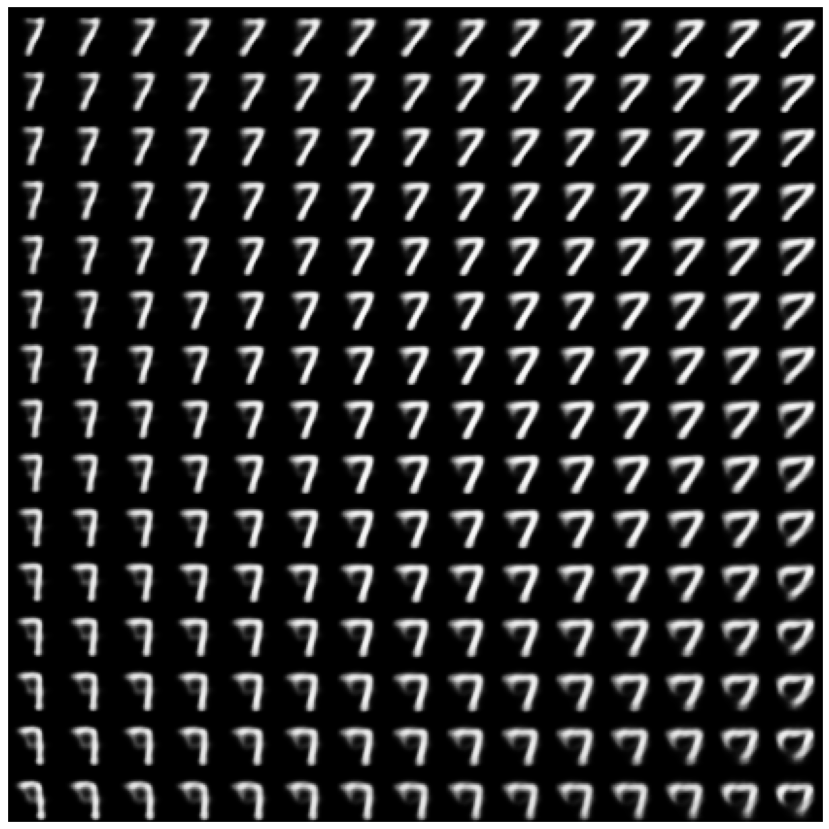

In [21]:
model.eval()
_img = draw_manifold(model, True, conditional=True, condition=7)

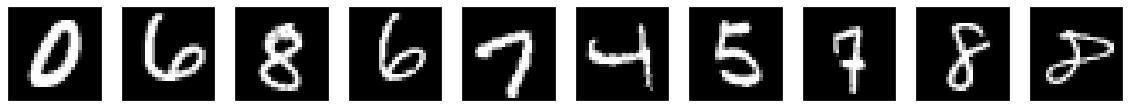

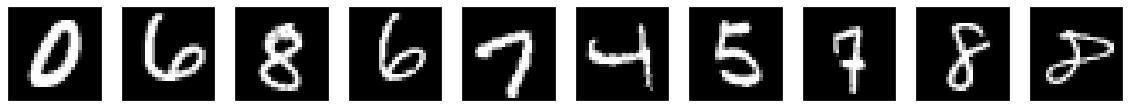

In [22]:
example = next(iter(train_loader))
plot_digits(example[0][:10])

In [23]:
model.eval()

ConditionalVariationalAutoEncoder(
  (embedding): Embedding(10, 5)
  (encoder): Sequential(
    (0): Linear(in_features=789, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (mu_repr): Linear(in_features=128, out_features=2, bias=True)
  (log_sigma_repr): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)

Select the desired start and end images. Also one migh just sample the latent representation from $\mathcal{N}(0, \mathbf{I})$.

In [32]:
from_to = (example[0][8:10], example[1][8:10])

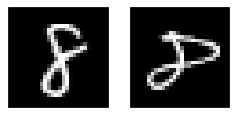

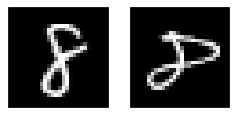

In [33]:
plot_digits(from_to[0]) # it duplicates the images because the original purpose of the plotting function was different

Predict the mean value for normal distribution in latent space.

In [34]:
out = model([x.to(device) for x in from_to])

Select start and end code

In [35]:
start = out[1][:1]
end = out[1][1:]

And simply interpolate the path between two representations

In [36]:
diff = (end-start) / 10
path = torch.cat([start+diff*i for i in range(11)], dim=0)
path.shape

torch.Size([11, 2])

Now reconstruct the images. Note that you can path the labels as `list` and path different labels as well.

In [43]:
image_path = model.decode(path, [8]*len(path))

torch.Size([11, 2]) torch.Size([11, 5])


And finally plot it. You might use it for your sake.

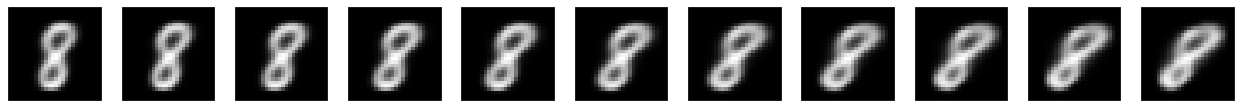

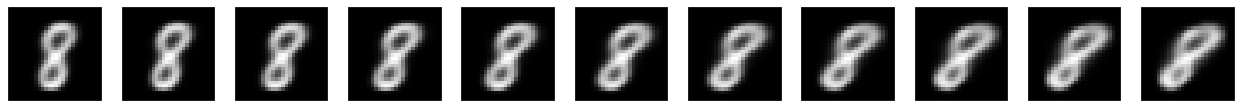

In [44]:
plot_digits(image_path.cpu().detach())

torch.Size([11, 2]) torch.Size([11, 5])


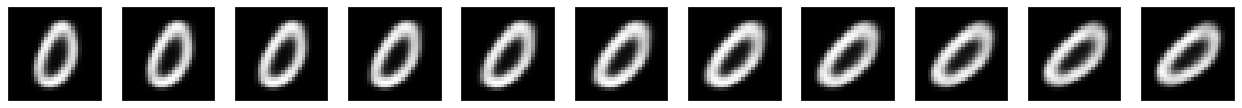

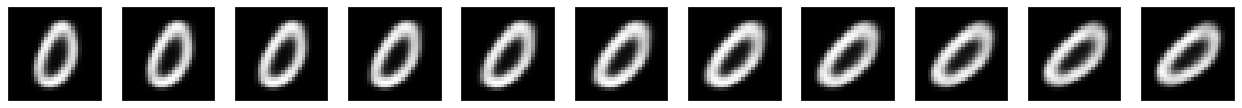

In [45]:
image_path = model.decode(path, [0]*len(path))
plot_digits(image_path.cpu().detach())